In [1]:
import cartopy.crs as ccrs
from cmocean import cm 
from dino import Experiment
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import cftime as cft
import xnemogcm as xn
import xgcm

In [2]:
path   = "/data/dkamm/nemo_output/DINO/"
dino_exp = Experiment(path, 'SaltRestoring/restart9')

In [7]:
T_star = dino_exp.get_T_star()
S_star = dino_exp.get_S_star()

In [5]:
rho_star = dino_exp.get_rho_star()

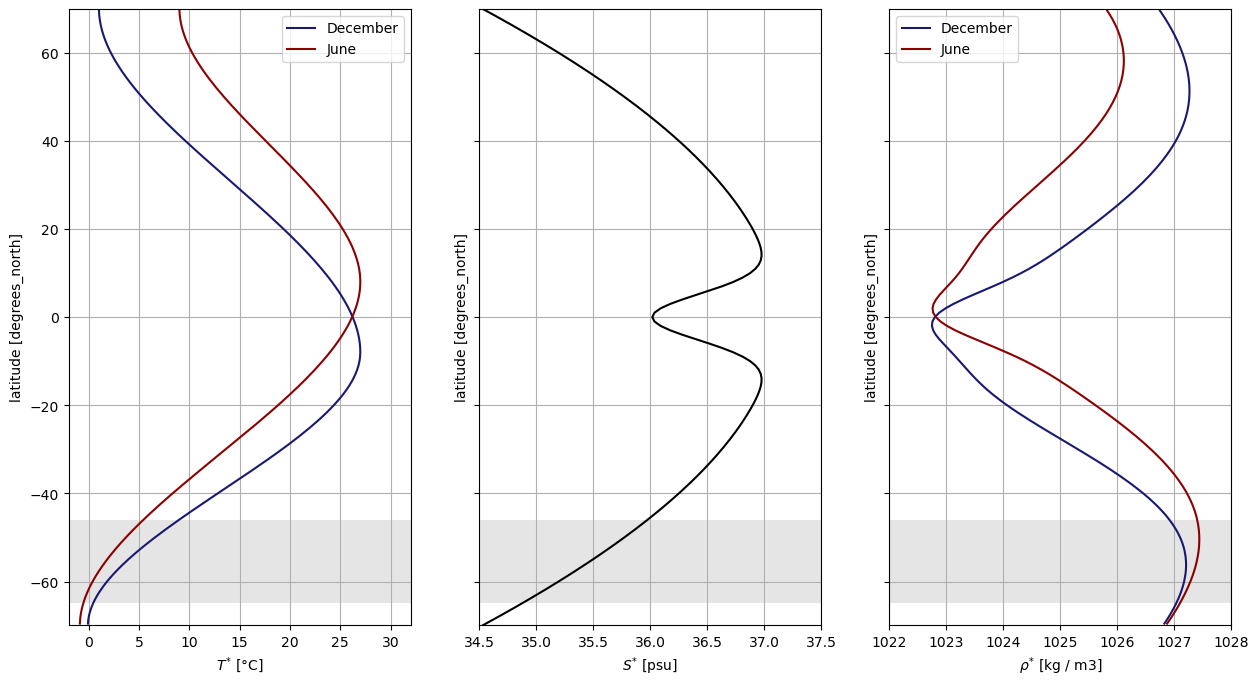

In [24]:
fig, axs = plt.subplots(1,3,figsize=(15,8), sharey=True)
T_star.isel(x_c=10, t_m=-1, y_c=slice(1,-1)).plot(color='midnightblue', y='gphit', ax=axs[0], label='December')
T_star.isel(x_c=10, t_m=-7, y_c=slice(1,-1)).plot(color='darkred', y='gphit', ax=axs[0], label='June')
S_star.isel(x_c=10).plot(color='black', y='gphit', ax=axs[1])
rho_star.isel(x_c=10, t_m=-1, y_c=slice(1,-1)).plot(color='midnightblue', y='gphit', ax=axs[2], label='December')
rho_star.isel(x_c=10, t_m=-7, y_c=slice(1,-1)).plot(color='darkred', y='gphit', ax=axs[2], label='June')

axs[0].fill_betweenx(dino_exp.domain.gphiu.values[:,0], -2, 32, where=dino_exp.domain.umask.isel(x_f=0, z_c=0)==1, facecolor='grey', alpha=.2)
axs[0].margins(x=0, y=0)
axs[0].set_xlabel(r"$T^{*}$ [°C]")
axs[0].set_title('')
axs[0].grid()
axs[0].legend()
#
axs[1].fill_betweenx(dino_exp.domain.gphiu.values[:,0], 34.5, 37.5, where=dino_exp.domain.umask.isel(x_f=0, z_c=0)==1, facecolor='grey', alpha=.2)
axs[1].margins(x=0, y=0)
axs[1].set_xlabel(r"$S^{*}$ [psu]")
axs[1].set_title('')
axs[1].grid()
#
axs[2].fill_betweenx(dino_exp.domain.gphiu.values[:,0], 1022, 1028, where=dino_exp.domain.umask.isel(x_f=0, z_c=0)==1, facecolor='grey', alpha=.2)
axs[2].margins(x=0, y=0)
axs[2].set_xlabel(r"$\rho^{*}$ [kg / m3]")
axs[2].set_title('')
axs[2].grid()
axs[2].legend()

## Why Is the density restoring decreasing towards the meridional boundaries? 
    - Problem in equation of state?
        --> EOS seems right, maybe issue in z used as as gdept_0? T restoring on w-, or T-points?
    - Find S_star with a density restoring towards Munday (2012) ?
        --> Include denser waters south of channel?

In [32]:
idx_n = abs(rho_star.gphit - (-40)).argmin()
idx_s = abs(rho_star.gphit - (-65)).argmin()